<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files%20/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import gdown
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed  # For parallel processing
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier


Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=a049d4fb-a524-4f1e-93a9-aeb2c59e492f
To: /content/dataset.csv
100%|██████████| 110M/110M [00:01<00:00, 61.9MB/s]


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
Total available samples: 60000
Training data shape: (48000, 784)
Test data shape: (12000, 784)


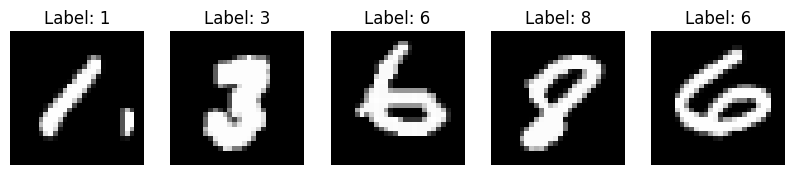

In [2]:
# File ID from Google Drive
file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
output = "dataset.csv"
gdown.download(url, output, quiet=False)

# Read CSV into Pandas DataFrame
df = pd.read_csv(output, header=None)  # No header in the dataset

# Preview dataset structure
print(df.head())

# Extract labels (first column) and features (remaining columns)
y = df.iloc[:, 0].values  # Labels
X = df.iloc[:, 1:].values  # Features (pixel values)

# Normalize pixel values (0-255 → 0-1)
X = X / 255.0

# Check available dataset size
total_samples = X.shape[0]
print(f"Total available samples: {total_samples}")

# Define split ratios
train_ratio = 0.8  # Use 80% for training, 20% for testing
train_size = int(total_samples * train_ratio)
test_size = total_samples - train_size  # Remaining for testing

# Split dataset while maintaining class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=42
)

# Verify shapes
print(f"Training data shape: {X_train.shape}")  # Should be around 80% of total samples
print(f"Test data shape: {X_test.shape}")       # Should be around 20% of total samples

# Check if reshaping to 28x28 is valid
num_features = X.shape[1]
image_size = int(np.sqrt(num_features))

if image_size * image_size == num_features:
    # Display some sample images
    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for i, ax in enumerate(axes):
        ax.imshow(X_train[i].reshape(image_size, image_size), cmap="gray")
        ax.set_title(f"Label: {y_train[i]}")
        ax.axis("off")

    plt.show()
else:
    print(f"Warning: Cannot reshape images to ({image_size}, {image_size}). Check dataset dimensions.")

In [3]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))


In [4]:
def best_split(X, y):
    best_feature, best_threshold, best_gain = None, None, 0
    for feature in range(X.shape[1]):
        values = np.unique(X[:, feature])
        for threshold in values:
            left_mask = X[:, feature] < threshold
            right_mask = ~left_mask
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue
            left_entropy = entropy(y[left_mask])
            right_entropy = entropy(y[right_mask])
            gain = entropy(y) - (np.sum(left_mask) / len(y)) * left_entropy - (np.sum(right_mask) / len(y)) * right_entropy
            if gain > best_gain:
                best_feature, best_threshold, best_gain = feature, threshold, gain
    return best_feature, best_threshold


In [5]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def build_tree(X, y, depth=0, max_depth=10):
    if len(np.unique(y)) == 1:
        return Node(value=np.unique(y)[0])
    if depth >= max_depth:
        return Node(value=np.bincount(y).argmax())
    feature, threshold = best_split(X, y)
    if feature is None:
        return Node(value=np.bincount(y).argmax())
    left_mask = X[:, feature] < threshold
    right_mask = ~left_mask
    left_subtree = build_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
    right_subtree = build_tree(X[right_mask], y[right_mask], depth + 1, max_depth)
    return Node(feature=feature, threshold=threshold, left=left_subtree, right=right_subtree)


In [6]:
def predict(tree, X):
    predictions = []
    for sample in X:
        node = tree
        while node.left or node.right:
            if sample[node.feature] < node.threshold:
                node = node.left
            else:
                node = node.right
        predictions.append(node.value)
    return np.array(predictions)


In [7]:
class RandomForest:
    def __init__(self, n_trees=20, max_depth=15, max_features="sqrt"):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]
            if self.max_features == "sqrt":
                n_features = int(np.sqrt(X.shape[1]))
            else:
                n_features = X.shape[1]
            feature_indices = np.random.choice(X.shape[1], n_features, replace=False)
            tree = build_tree(X_sample[:, feature_indices], y_sample, max_depth=self.max_depth)
            self.trees.append((tree, feature_indices))

    def predict(self, X):
        predictions = np.zeros((self.n_trees, len(X)))
        for i, (tree, feature_indices) in enumerate(self.trees):
            predictions[i] = predict(tree, X[:, feature_indices])
        return np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)


In [8]:
rf = RandomForest(n_trees=20, max_depth=15, max_features="sqrt")
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


In [9]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted') * 100
    recall = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100

    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")

evaluate_model(y_test, y_pred)


Precision: 89.98%
Recall: 89.94%
F1 Score: 89.89%



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1185
           1       0.89      0.99      0.94      1348
           2       0.90      0.91      0.90      1192
           3       0.84      0.89      0.86      1226
           4       0.89      0.88      0.88      1168
           5       0.93      0.85      0.89      1084
           6       0.94      0.95      0.95      1184
           7       0.90      0.88      0.89      1253
           8       0.91      0.83      0.87      1170
           9       0.85      0.83      0.84      1190

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



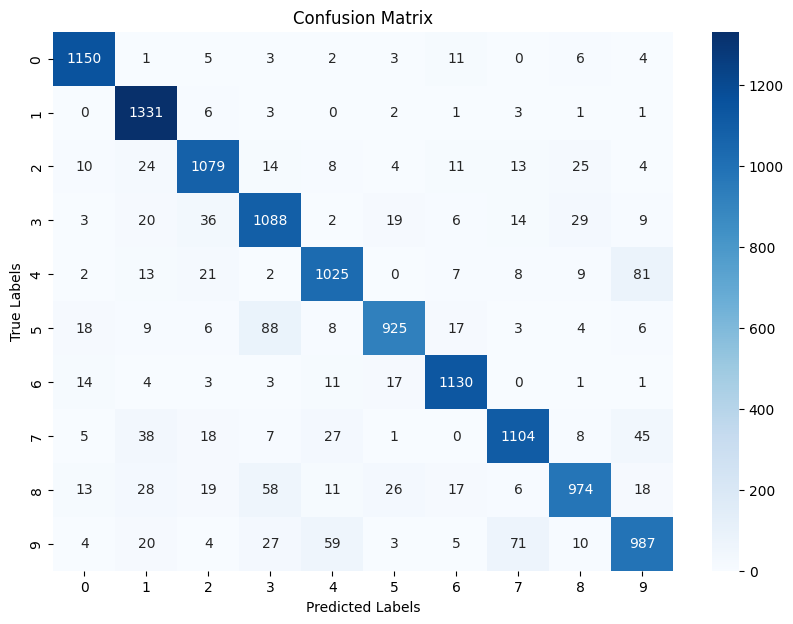

In [10]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


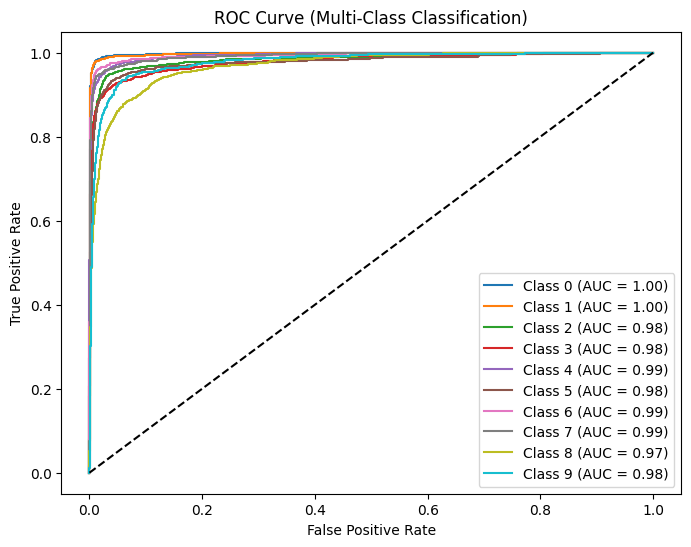

In [11]:
# Convert labels to one-hot encoding for multi-class ROC
y_train_bin = label_binarize(y_train, classes=np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_train_bin.shape[1]

# Train a One-vs-Rest Logistic Regression Model
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, y_train_bin)

# Get probability predictions
y_score = clf.predict_proba(X_test)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc:.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multi-Class Classification)")
plt.legend()
plt.show()


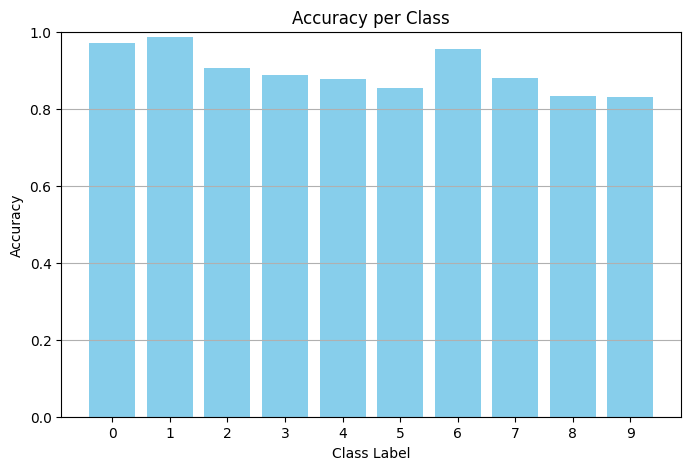

In [12]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute Accuracy per Class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_accuracy = np.nan_to_num(class_accuracy)  # Replace NaN with 0 for empty classes

# Plot Accuracy per Class
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_accuracy)), class_accuracy, color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy per Class")
plt.xticks(range(len(class_accuracy)))
plt.grid(axis="y")
plt.show()


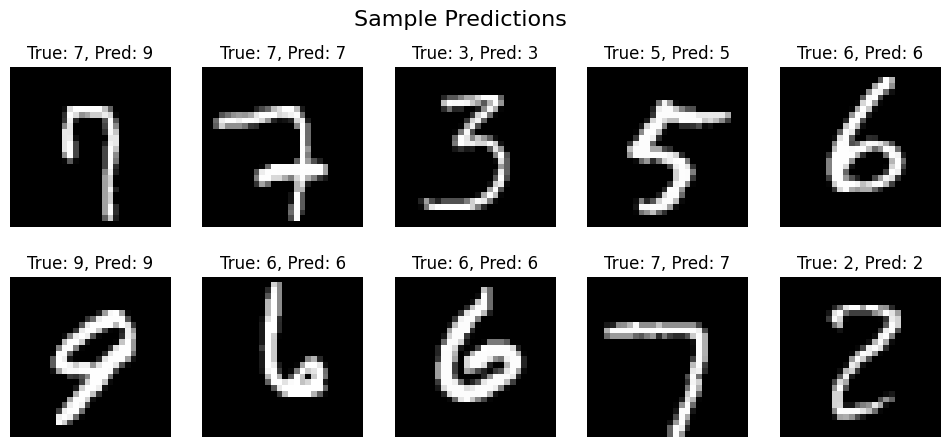

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Sample Predictions", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred[i]}")
    ax.axis("off")

plt.show()

